# Jitter model for TOLIMAN
In order to properly recover the signal seen by TOLIMAN, we need to understand and account for the jitter of the spacecraft. In this notebook we will to develop a basic jitter model with dLux.

----
## Setup
First let's get the housekeeping out of the way.

In [3]:
import dLux as dl
import jax.numpy as np
from jax import random as jr
from jax import vmap
from matplotlib import pyplot as plt
import os

import utils

os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Let's set our physical parameters for modelling Alpha Centauri:

In [4]:
sep = 10  # binary separation in arcseconds
pa = 90  # position angle in degrees
flux = 6.229e7 / 10 / 2  # AVERAGE flux of the two stars per frame
contrast = 3.372873  # flux contrast from V band magnitudes
bandwidth_min = 545  # minimum wavelength in nm
bandwidth_max = 645  # maximum wavelength in nm

And our parameters for the optical system:

In [5]:
wavefront_npixels = 256  # Number of pixels representing the wavefront
detector_npixels = 128  # Number of pixels in the detector
sampling_rate = 5  # five times Nyquist sampling
wavels = 1e-9 * np.linspace(bandwidth_min, bandwidth_max, 3)  # the wavelengths modelled
pixel_scale_in = dl.utils.get_pixel_scale(sampling_rate, wavels.max(), aperture=0.125, focal_length=None)  # radians per pixel
pixel_scale_out = 0.3 # arcseconds per pixel

Loading in the binary phase mask:

In [6]:
mask_dir = 'data/toliman_pupil.npy'
mask = dl.optics.AddOPD(dl.utils.phase_to_opd(np.load(mask_dir), wavelength=wavels.mean()))

Let's create the system optics and source and combine them to create the instrument:

In [7]:
# Make optical system
optics = dl.utils.toliman(wavefront_npixels,
                          detector_npixels,
                          detector_pixel_size=dl.utils.radians_to_arcseconds(pixel_scale_in),
                          extra_layers=[mask],
                          angular=True,
                          )

# Resetting the pixel scale of output
optics = optics.set(['AngularMFT.pixel_scale_out'], [dl.utils.arcseconds_to_radians(pixel_scale_out)])

# Creating a model Alpha Cen source
source = dl.BinarySource(separation=dl.utils.arcseconds_to_radians(sep),
                         wavelengths=wavels,
                         contrast=contrast,
                         flux=flux,
                         position_angle=np.deg2rad(pa),
                         )

Plotting the jitterless PSF:

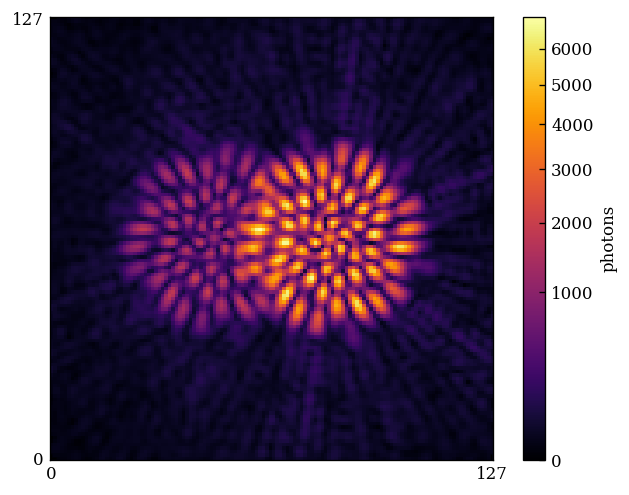

In [8]:
import utils  # see utils.py for plotting code
PSF = optics.model(source)
utils.PlotSqrtPSF(PSF)

____
## Modelling the (linear) Jitter

We are going to the model the jitter as the normalised sum of several identical shifted PSFs. The challenge is to identify a number of PSFs (`npsf`) that is sufficient to represent a continuous motion, but not so many that the computation time becomes prohibitive. For now, let's set it at 10.

We are going to parameterise the jitter as a radial vector, taking on a radius and angle as inputs. Additionally, we need to specify the centre of the jitter, which will require two more parameters.

In [9]:
# Defining a function to set the source position and propagate through the optics
def set_and_model(optics, source, pos):
    src = source.set(['position'], [pos])
    return optics.model(src)

vmap_prop = vmap(set_and_model, in_axes=(None, None, 0))
pscale = optics.AngularMFT.pixel_scale_out  # arcseconds per pixel

def jitter_psf(rad: float, angle: float = 0, centre: tuple = (0,0), npsf: int = 10):
    """
    Returns a jittered PSF by summing a number of shifted PSFs.

    Parameters
    ----------
    rad : float
        The radius of the jitter in pixels.
    angle : float, optional
        The angle of the jitter in degrees, by default 0
    centre : tuple, optional
        The centre of the jitter in pixels, by default (0,0)
    npsf : int, optional
        The number of PSFs to sum, by default 10

    Returns
    -------
    np.ndarray
        The jittered PSF.
    """

    angle = np.deg2rad(angle) # converting to radius

    # converting to cartesian coordinates
    x = rad/2 * np.cos(angle)
    y = rad/2 * np.sin(angle)
    xs = np.linspace(-x, x, npsf)  # pixels
    ys = np.linspace( -y, y, npsf)  # pixels
    positions = pscale * (np.stack([xs, ys], axis=1) + np.array(centre))  # arcseconds

    psfs = vmap_prop(optics, source, positions)
    jit_psf = psfs.sum(0) / npsf  # adding and renormalising

    return jit_psf

We are using `jax.vmap` to vectorise this operation. Each PSF is then summed and renormalised to give the jittered PSF.

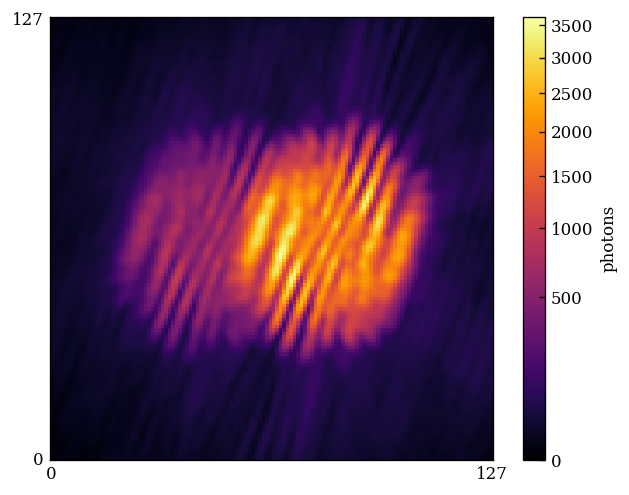

In [19]:
jit_psf = jitter_psf(rad=20, angle=70, centre=(0,0), npsf=20)
utils.PlotSqrtPSF(jit_psf)

This is a good proof of concept. This amount of jitter is huge and unrealistic, but it shows that the model is working. Furthermore, it seems that 10 PSFs are sufficient for this level of jitter to appear as a continuous motion -- at least visually.

Let's create a "perfect jitter" example (with `npsf=100`) and compare it to the jitterless PSF for a **radial jitter of half a pixel**.

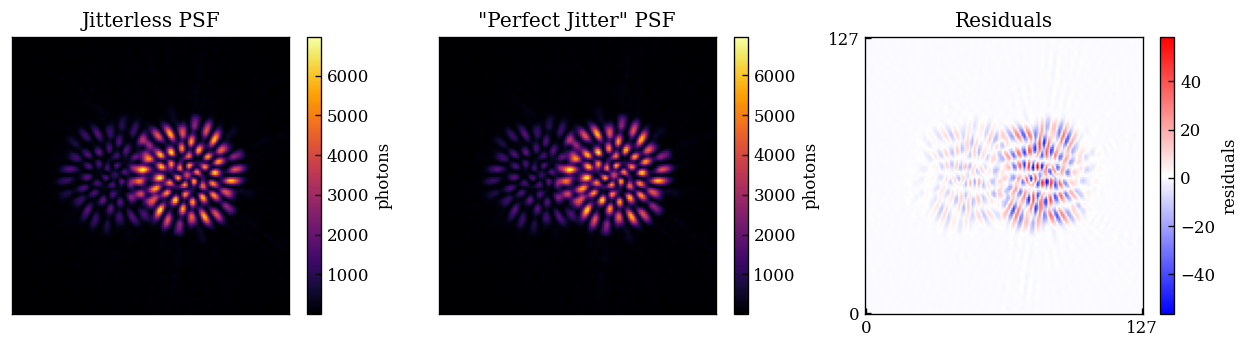

In [11]:
perf_jit_psf = jitter_psf(rad=.5, angle=0, centre=(0,0), npsf=100)

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(13,3))
c1 = ax1.imshow(PSF); ax1.set(title='Jitterless PSF', xticks=[], yticks=[])
c2 = ax2.imshow(perf_jit_psf); ax2.set(title='"Perfect Jitter" PSF', xticks=[], yticks=[])
c3 = ax3.imshow(perf_jit_psf - PSF, cmap='bwr')
ax3.set(
        title='Residuals',
        xticks=[0, PSF.shape[0] - 1],
        yticks=[0, PSF.shape[1] - 1],
        )
fig.colorbar(c1, ax=ax1, label='photons')
fig.colorbar(c2, ax=ax2, label='photons')
fig.colorbar(c3, ax=ax3, label='residuals')
plt.show()

The amount of jitter is small enough that the two PSFs are identical at a glance. However the residual plot demonstrates our model does indeed work on a subpixel scale.

____
## Optimising npsf
We would like to find the minimum number of PSFs required to represent a given jitter. We can do this by comparing the residuals of the jittered PSF to the "perfect jitter" PSF.

In [12]:
%%time
import numpy  # for array operations

n_psfs = np.arange(19) + 2
rad_tests = [0.05, 0.1, 0.25, 0.4, 0.6, 0.8, 1, 1.5, 2]
angle_tests = [0, 30, 45, 60, 90]
residuals = numpy.zeros(shape=(len(rad_tests), len(angle_tests), len(n_psfs)))

for i in range(len(rad_tests)):
    for j in range(len(angle_tests)):
        perf_jit_psf = numpy.array(jitter_psf(rad=rad_tests[i], angle=angle_tests[j], centre=(0,0), npsf=100))
        for k in n_psfs:
            jit_psf = numpy.array(jitter_psf(rad=rad_tests[i], angle=angle_tests[j], centre=(0,0), npsf=k))
            resid_psf = numpy.abs(perf_jit_psf - jit_psf)
            residuals[i][j][k-2] = resid_psf.sum()

CPU times: user 5min 24s, sys: 36.1 s, total: 6min
Wall time: 1min 52s


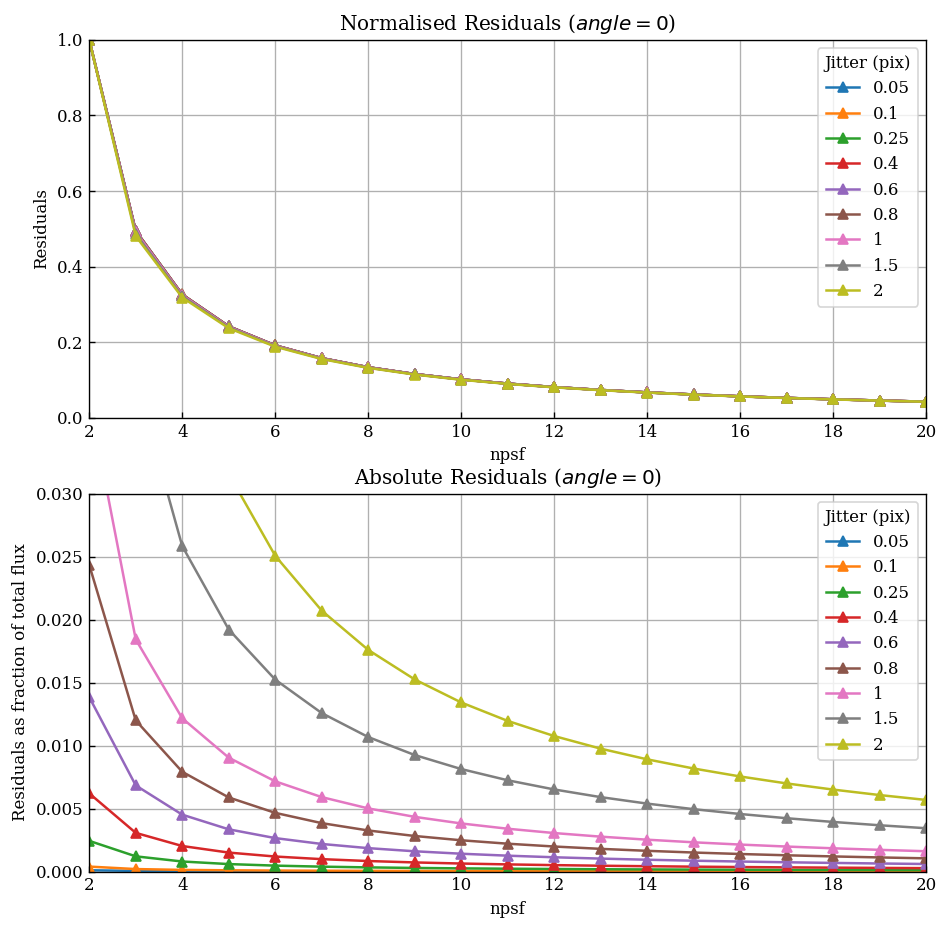

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,9))

for i in range(len(rad_tests)):
    ax[0].plot(n_psfs, residuals[i][0]/residuals[i][0].max(), marker='^', label=f'{rad_tests[i]}')
    ax[1].plot(n_psfs, residuals[i][0]/(flux*2), marker='^', label=f'{rad_tests[i]}')

ax[0].set(
    xlabel='npsf',
    ylabel='Residuals',
    title=r'Normalised Residuals ($angle=0$)',
    xlim=(2, n_psfs.max()),
    ylim=(0, 1.),
    # yscale='log',
)
ax[1].set(
    xlabel='npsf',
    ylabel='Residuals as fraction of total flux',
    title='Absolute Residuals ($angle=0$)',
    xlim=(2, n_psfs.max()),
    ylim=(0,.03),
)
ax[0].grid()
ax[1].grid()
ax[0].legend(title='Jitter (pix)')
ax[1].legend(title='Jitter (pix)', loc='upper right')
plt.show()

Okay. The top plot demonstrates that shape of these residual vs `npsf` curves are independent of the jitter radius. The bottom plot will help inform our model how many wavelengths to model for a given jitter radius -- we simply need to decide a threshold for the residuals.

____
## Investigating effect of jitter angle
Let's investigate what happens when we vary the angle of the jitter with respect to the position angle of Alpha Centauri (which we will keep fixed at `pa=90`). We will investigate the residuals at a jitter radius of 0.5 pixels.

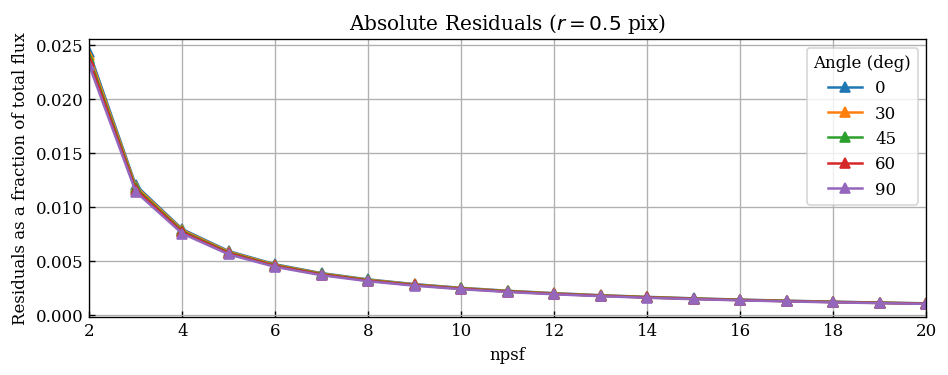

In [14]:
fig, ax = plt.subplots(figsize=(9,3))

for i in range(len(angle_tests)):
    ax.plot(n_psfs, residuals[5][i]/(flux*2), marker='^', label=f'{angle_tests[i]}')

ax.set(
    xlabel='npsf',
    ylabel='Residuals as a fraction of total flux',
    title='Absolute Residuals ($r=0.5$ pix)',
    xlim=(2, n_psfs.max()),
    # yscale='log',
)
ax.grid()
ax.legend(title='Angle (deg)')
plt.show()

The residuals seem to be independent of the jitter angle. This is good news, as it means we can use the same number of PSFs for all angles of jitter.

To be thorough, let us check all the jitter radii and angles together to rule out any possibility of covariance between the two parameters. The following plots have the jitter radius and jitter angle on the y and x axes respectively, coloured by the residuals. This plot is created for each `npsf` value.



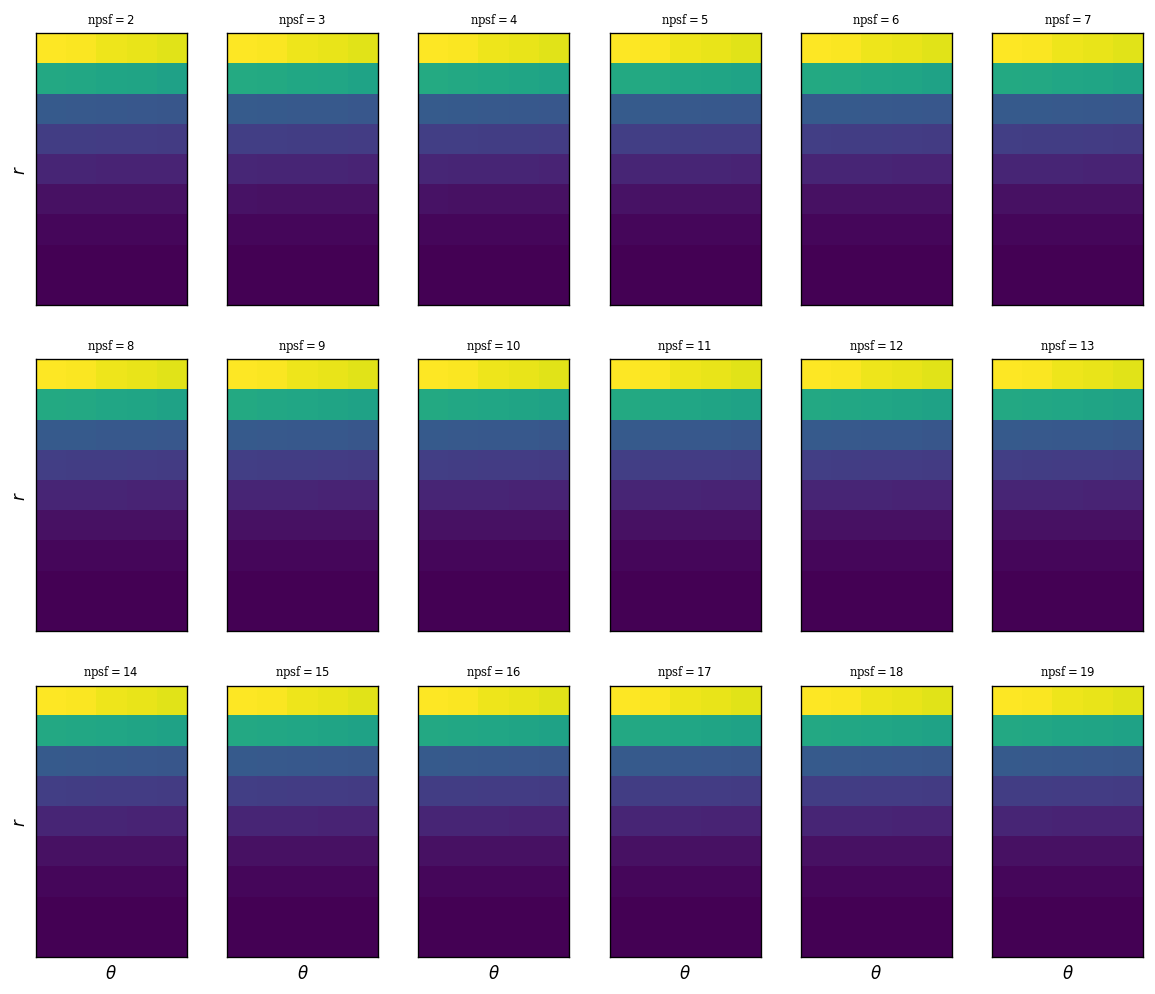

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(12,10), sharex=True, sharey=True)
npsf_counter=2
for i in range(3):
    for j in range(6):
        ax[i][j].imshow(residuals[:,:,npsf_counter-2], cmap='viridis')
        ax[i][j].set(xticks=[], yticks=[],)
        if i%3==2:
            ax[i][j].set_xlabel(xlabel=r'$\theta$', fontsize = 10)
        if j%6==0:
            ax[i][j].set_ylabel(ylabel=r'$r$', fontsize = 10)
        ax[i][j].set_title(label=r'npsf$={0}$'.format(npsf_counter), fontsize=7)
        npsf_counter += 1


Thankfully no covariance is apparent, so we can assume that the residuals are entirely independent of the jitter angle.